# Autoregressive 1-Day Stock Prediction (Close-Only Features)

## Overview
This notebook implements an **autoregressive approach** where we:
- Predict **only 1 day ahead** at a time
- Use **only features derivable from close price** (no OHLV data)
- **Autoregressively predict** 7 times to get 7-day forecast

### Why This Approach?
1. **Feature Consistency**: Can reconstruct all features from predicted close price
2. **Stronger Signal**: 1-day predictions are easier than 7-day predictions
3. **Error Tracking**: Can measure how errors compound over time
4. **Comparison**: Test if simpler features + autoregressive beats complex features

### Key Differences from Previous Approach:
- **Features**: ~10 close-derived features (vs 32 full features)
- **Target**: 1-day return (vs 7-day return)
- **Inference**: Loop 7 times, updating features (vs single prediction)
- **Trade-off**: Simpler features but compounding errors

### Models Evaluated:
1. LSTM (best for autoregressive sequences)
2. GRU (faster alternative)
3. Linear Regression (baseline)

---
## 1. Imports and Setup

In [1]:
# Standard libraries
import os
import glob
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Progress bars
from tqdm.auto import tqdm

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.keras

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

2025-11-13 21:30:12.994624: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 21:30:17.632574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 21:30:25.034926: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


All libraries imported successfully
TensorFlow version: 2.20.0


In [2]:
# Configuration
WINDOW_SIZE = 60          # Input: past 60 days
HORIZON = 7               # Forecast: 7 days ahead (autoregressively)
TEST_STOCK_RATIO = 0.2
RANDOM_STATE = 42

# Paths
DATA_DIR = Path("data/processed/stock_data")
MODELS_DIR = Path("models")
MLFLOW_DIR = Path("mlruns")

MODELS_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"MLflow tracking: {MLFLOW_DIR}")

Data directory: data/processed/stock_data
Models directory: models
MLflow tracking: mlruns


In [3]:
# MLflow Setup
mlflow.set_tracking_uri(f"file://{MLFLOW_DIR.absolute()}")
mlflow.set_experiment("stock-autoregressive-1day-prediction")

experiment = mlflow.get_experiment_by_name("stock-autoregressive-1day-prediction")
print(f"MLflow Experiment: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

MLflow Experiment: stock-autoregressive-1day-prediction
Experiment ID: 632482873268849688
Artifact Location: file:///home/labeeb/Desktop/stock-curator/mlruns/632482873268849688


---
## 2. Load Data & Create Close-Only Features

In [4]:
# Load all stock CSV files
csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))

print(f"Found {len(csv_files)} stock CSV files")
print(f"\nFirst 5 files:")
for f in csv_files[:5]:
    print(f"  - {Path(f).name}")

Found 98 stock CSV files

First 5 files:
  - ABBOTINDIA_historical.csv
  - ABB_historical.csv
  - ADANIENT_historical.csv
  - ADANIGREEN_historical.csv
  - ADANIPORTS_historical.csv


In [5]:
def create_close_only_features(df):
    """
    Create features ONLY from close price.
    These can be reconstructed in autoregressive loop.
    """
    df = df.copy()
    
    # Keep only Date and Close initially
    df = df[['Date', 'Close']].copy()
    
    # Moving averages
    df['SMA_5'] = df['Close'].rolling(5).mean()
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    
    # Exponential moving averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    
    # Returns
    df['Return_1d'] = df['Close'].pct_change(1) * 100
    df['Return_3d'] = df['Close'].pct_change(3) * 100
    df['Return_5d'] = df['Close'].pct_change(5) * 100
    
    # Momentum
    df['Momentum_10d'] = df['Close'] - df['Close'].shift(10)
    df['Momentum_20d'] = df['Close'] - df['Close'].shift(20)
    
    # Volatility (std of returns)
    df['Volatility_5d'] = df['Return_1d'].rolling(5).std()
    df['Volatility_20d'] = df['Return_1d'].rolling(20).std()
    
    # Price rate of change
    df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100
    
    # Drop NaN rows
    df = df.dropna()
    
    return df


def load_and_process_stock(file_path):
    """Load stock and create close-only features."""
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Create close-only features
    df = create_close_only_features(df)
    
    # Need sufficient data
    if len(df) < WINDOW_SIZE + HORIZON:
        return None
    
    return df


# Load all stocks
print("\nLoading stocks and creating close-only features...")
stock_data = {}
skipped = []

for file_path in tqdm(csv_files, desc="Processing stocks"):
    symbol = Path(file_path).stem.replace('_historical', '')
    df = load_and_process_stock(file_path)
    
    if df is not None:
        stock_data[symbol] = df
    else:
        skipped.append(symbol)

print(f"\nLoaded {len(stock_data)} stocks successfully")
if skipped:
    print(f"Skipped {len(skipped)} stocks: {skipped}")


Loading stocks and creating close-only features...


Processing stocks:   0%|          | 0/98 [00:00<?, ?it/s]


Loaded 98 stocks successfully


In [6]:
# Inspect sample data
sample_symbol = list(stock_data.keys())[0]
sample_df = stock_data[sample_symbol]

print(f"\nSample Stock: {sample_symbol}")
print(f"Shape: {sample_df.shape}")
print(f"Date Range: {sample_df['Date'].min()} to {sample_df['Date'].max()}")

# Define feature columns (exclude Date)
feature_cols = [col for col in sample_df.columns if col != 'Date']

print(f"\nClose-Only Feature Columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\nFirst 3 rows:")
print(sample_df.head(3))


Sample Stock: ABBOTINDIA
Shape: (447, 16)
Date Range: 2024-01-15 00:00:00+05:30 to 2025-10-31 00:00:00+05:30

Close-Only Feature Columns (15):
   1. Close
   2. SMA_5
   3. SMA_10
   4. SMA_20
   5. SMA_50
   6. EMA_12
   7. EMA_26
   8. Return_1d
   9. Return_3d
  10. Return_5d
  11. Momentum_10d
  12. Momentum_20d
  13. Volatility_5d
  14. Volatility_20d
  15. ROC_10

First 3 rows:
                        Date     Close     SMA_5     SMA_10      SMA_20  \
49 2024-01-15 00:00:00+05:30  26210.45  25228.03  24418.650  23511.0825   
50 2024-01-16 00:00:00+05:30  25806.50  25542.95  24666.575  23662.3925   
51 2024-01-17 00:00:00+05:30  25730.70  25767.24  24878.985  23803.8150   

       SMA_50        EMA_12        EMA_26  Return_1d  Return_3d  Return_5d  \
49  23457.478  24458.690436  23817.199793   1.792504   6.506497  10.788483   
50  23517.685  24666.045754  23964.555364  -1.541179   1.842370   6.498046   
51  23566.019  24829.838715  24095.380892  -0.293724  -0.070683   4.557026   

---
## 3. Create Training Sequences (1-Day Prediction)

In [7]:
def create_1day_sequences(df, window_size=60):
    """
    Create sequences for 1-day ahead prediction.
    
    Returns:
        X: (n_samples, window_size, n_features)
        y_return: (n_samples,) - next 1-day return %
        y_direction: (n_samples,) - 1 if UP, 0 if DOWN
    """
    features = df[feature_cols].values
    close_prices = df['Close'].values
    
    X, y_return, y_direction = [], [], []
    
    # Predict only 1 day ahead
    for i in range(len(df) - window_size):
        # Input: past window_size days
        X.append(features[i:i + window_size])
        
        # Current and next close
        current_close = close_prices[i + window_size - 1]
        next_close = close_prices[i + window_size]
        
        # 1-day return and direction
        return_1d = ((next_close - current_close) / current_close) * 100
        direction = 1 if next_close > current_close else 0
        
        y_return.append(return_1d)
        y_direction.append(direction)
    
    return np.array(X), np.array(y_return), np.array(y_direction)


# Test on sample
X_test, y_ret_test, y_dir_test = create_1day_sequences(sample_df, WINDOW_SIZE)

print(f"\nTest Sequence Creation on {sample_symbol}:")
print(f"  X shape:           {X_test.shape}")
print(f"  y_return shape:    {y_ret_test.shape}")
print(f"  y_direction shape: {y_dir_test.shape}")
print(f"\n  Example 1-day prediction:")
print(f"    Return:    {y_ret_test[0]:.3f}%")
print(f"    Direction: {y_dir_test[0]} ({'UP' if y_dir_test[0] == 1 else 'DOWN'})")
print(f"\n  Class distribution:")
print(f"    UP:   {np.sum(y_dir_test == 1)} ({np.mean(y_dir_test == 1)*100:.1f}%)")
print(f"    DOWN: {np.sum(y_dir_test == 0)} ({np.mean(y_dir_test == 0)*100:.1f}%)")


Test Sequence Creation on ABBOTINDIA:
  X shape:           (387, 60, 15)
  y_return shape:    (387,)
  y_direction shape: (387,)

  Example 1-day prediction:
    Return:    -2.136%
    Direction: 0 (DOWN)

  Class distribution:
    UP:   181 (46.8%)
    DOWN: 206 (53.2%)


---
## 4. Train/Test Split & Data Preparation

In [8]:
# Split stocks
stock_symbols = list(stock_data.keys())
n_test_stocks = int(len(stock_symbols) * TEST_STOCK_RATIO)

np.random.seed(RANDOM_STATE)
shuffled_symbols = np.random.permutation(stock_symbols)

train_symbols = shuffled_symbols[:-n_test_stocks]
test_symbols = shuffled_symbols[-n_test_stocks:]

print(f"\nStock Split:")
print(f"  Training stocks: {len(train_symbols)} ({len(train_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"  Test stocks:     {len(test_symbols)} ({len(test_symbols)/len(stock_symbols)*100:.1f}%)")


Stock Split:
  Training stocks: 79 (80.6%)
  Test stocks:     19 (19.4%)


In [9]:
# Create training sequences
print("\nCreating training sequences...")
X_train_list, y_return_train_list, y_dir_train_list = [], [], []

for symbol in tqdm(train_symbols, desc="Processing train stocks"):
    df = stock_data[symbol]
    X, y_ret, y_dir = create_1day_sequences(df, WINDOW_SIZE)
    X_train_list.append(X)
    y_return_train_list.append(y_ret)
    y_dir_train_list.append(y_dir)

X_train = np.concatenate(X_train_list, axis=0)
y_return_train = np.concatenate(y_return_train_list, axis=0)
y_direction_train = np.concatenate(y_dir_train_list, axis=0)

print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_return_train: {y_return_train.shape}")
print(f"  y_direction_train: {y_direction_train.shape}")


Creating training sequences...


Processing train stocks:   0%|          | 0/79 [00:00<?, ?it/s]


Training set:
  X_train: (30573, 60, 15)
  y_return_train: (30573,)
  y_direction_train: (30573,)


In [10]:
# Feature scaling
print("\nScaling features...")

n_train_samples, window_size, n_features = X_train.shape

X_train_2d = X_train.reshape(-1, n_features)

scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(n_train_samples, window_size, n_features)

print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  Targets NOT scaled (returns already normalized)")


Scaling features...
  X_train_scaled: (30573, 60, 15)
  Targets NOT scaled (returns already normalized)


---
## 5. Autoregressive Prediction Function

In [11]:
def autoregressive_predict_7days(model, initial_window, scaler, n_days=7):
    """
    Autoregressively predict 7 days into the future.
    
    Args:
        model: Trained model that predicts 1-day return
        initial_window: (window_size, n_features) - initial 60-day window
        scaler: StandardScaler for features
        n_days: Number of days to predict (default 7)
    
    Returns:
        predicted_returns: List of 7 predicted returns
        predicted_directions: List of 7 predicted directions
        predicted_closes: List of 7 predicted close prices
    """

    predicted_returns = []
    predicted_directions = []
    predicted_closes = []
    
    # Current window (will be updated)
    current_window = initial_window.copy()
    current_close = initial_window[-1, 0]  # Close is first feature
    
    # Check if model is Keras or sklearn
    is_keras_model = hasattr(model, 'fit') and hasattr(model, 'layers')
    
    for day in range(n_days):
        # Scale current window
        window_scaled = scaler.transform(current_window)  # (60, 15) -> (60, 15)
        
        # Predict next day's return
        if is_keras_model:
            # Keras models expect 3D input: (batch, timesteps, features)
            window_input = window_scaled.reshape(1, WINDOW_SIZE, n_features)
            pred_return = model.predict(window_input, verbose=0)[0, 0]
        else:
            # Sklearn models expect 2D input: (samples, features) - flattened
            window_input = window_scaled.reshape(1, -1)
            pred_return = model.predict(window_input)[0]
        
        # Calculate next close price
        next_close = current_close * (1 + pred_return / 100)
        
        # Direction
        direction = 1 if pred_return > 0 else 0
        
        # Store predictions
        predicted_returns.append(pred_return)
        predicted_directions.append(direction)
        predicted_closes.append(next_close)
        
        # Update window: remove oldest day, add new prediction
        new_features = reconstruct_features_from_close(
            current_window[:, 0],  # Historical closes
            next_close
        )
        
        # Update window (shift left, add new)
        current_window = np.vstack([current_window[1:], new_features])
        current_close = next_close
    
    return predicted_returns, predicted_directions, predicted_closes


def reconstruct_features_from_close(historical_closes, new_close):
    """
    Reconstruct all features from close price history.
    
    Args:
        historical_closes: Array of past close prices
        new_close: New close price to add
    
    Returns:
        features: (n_features,) array of reconstructed features
    """
    # Append new close to history
    all_closes = np.append(historical_closes, new_close)
    
    # Calculate features (same as create_close_only_features but for single row)
    features = []
    
    # Close
    features.append(new_close)
    
    # SMAs
    features.append(np.mean(all_closes[-5:]) if len(all_closes) >= 5 else new_close)
    features.append(np.mean(all_closes[-10:]) if len(all_closes) >= 10 else new_close)
    features.append(np.mean(all_closes[-20:]) if len(all_closes) >= 20 else new_close)
    features.append(np.mean(all_closes[-50:]) if len(all_closes) >= 50 else new_close)
    
    # EMAs (simplified - use SMA as approximation)
    features.append(np.mean(all_closes[-12:]) if len(all_closes) >= 12 else new_close)
    features.append(np.mean(all_closes[-26:]) if len(all_closes) >= 26 else new_close)
    
    # Returns
    ret_1d = ((new_close - all_closes[-2]) / all_closes[-2] * 100) if len(all_closes) >= 2 else 0
    ret_3d = ((new_close - all_closes[-4]) / all_closes[-4] * 100) if len(all_closes) >= 4 else 0
    ret_5d = ((new_close - all_closes[-6]) / all_closes[-6] * 100) if len(all_closes) >= 6 else 0
    features.extend([ret_1d, ret_3d, ret_5d])
    
    # Momentum
    mom_10 = (new_close - all_closes[-11]) if len(all_closes) >= 11 else 0
    mom_20 = (new_close - all_closes[-21]) if len(all_closes) >= 21 else 0
    features.extend([mom_10, mom_20])
    
    # Volatility (simplified)
    if len(all_closes) >= 6:
        returns = np.diff(all_closes[-6:]) / all_closes[-6:-1] * 100
        vol_5d = np.std(returns)
    else:
        vol_5d = 0
    
    if len(all_closes) >= 21:
        returns = np.diff(all_closes[-21:]) / all_closes[-21:-1] * 100
        vol_20d = np.std(returns)
    else:
        vol_20d = 0
    
    features.extend([vol_5d, vol_20d])
    
    # ROC
    roc_10 = ((new_close - all_closes[-11]) / all_closes[-11] * 100) if len(all_closes) >= 11 else 0
    features.append(roc_10)
    
    return np.array(features)


print("Autoregressive prediction functions defined")

Autoregressive prediction functions defined


---
## 6. Helper Functions for Evaluation

In [12]:
def calculate_metrics_by_horizon(y_true_list, y_pred_list, horizons=7):
    """
    Calculate metrics for each prediction horizon (day 1, 2, ..., 7).
    
    Args:
        y_true_list: List of true values for each sample, shape (n_samples, horizons)
        y_pred_list: List of predictions for each sample, shape (n_samples, horizons)
    """
    metrics = {}
    
    for day in range(1, horizons + 1):
        y_true_day = [sample[day-1] for sample in y_true_list]
        y_pred_day = [sample[day-1] for sample in y_pred_list]
        
        mae = mean_absolute_error(y_true_day, y_pred_day)
        rmse = np.sqrt(mean_squared_error(y_true_day, y_pred_day))
        
        metrics[f'mae_day{day}'] = mae
        metrics[f'rmse_day{day}'] = rmse
    
    # Average across all days
    metrics['mean_mae'] = np.mean([metrics[f'mae_day{d}'] for d in range(1, horizons + 1)])
    metrics['mean_rmse'] = np.mean([metrics[f'rmse_day{d}'] for d in range(1, horizons + 1)])
    
    return metrics


def calculate_direction_metrics(y_true_list, y_pred_list):
    """Calculate directional accuracy for 7-day cumulative direction."""
    # For each sample, check if cumulative direction matches
    # Cumulative direction = sign of sum of returns
    
    y_true_cumulative = [1 if sum(sample) > 0 else 0 for sample in y_true_list]
    y_pred_cumulative = [1 if sum(sample) > 0 else 0 for sample in y_pred_list]
    
    acc = accuracy_score(y_true_cumulative, y_pred_cumulative)
    prec = precision_score(y_true_cumulative, y_pred_cumulative, zero_division=0)
    rec = recall_score(y_true_cumulative, y_pred_cumulative, zero_division=0)
    f1 = f1_score(y_true_cumulative, y_pred_cumulative, zero_division=0)
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }


def calculate_sharpe_ratio(returns):
    """Calculate Sharpe ratio."""
    if len(returns) == 0 or np.std(returns) == 0:
        return 0.0
    return np.mean(returns) / np.std(returns)


def simulate_trading_autoregressive(y_return_true_list, y_return_pred_list,
                                   position_size=1000, transaction_cost=0.001):
    """
    Simulate trading with fair capital allocation for model comparison.

    Key Principle:
    - Each trade gets the SAME position size (₹1,000 by default)
    - Initial capital = position_size × number of trades
    - This ensures models with different trade frequencies are fairly compared
    - Total return % is directly comparable across models

    Strategy:
    - Trade if cumulative predicted return > 0
    - Each trade invests position_size for 7-day period

    Args:
        position_size: Amount invested per trade (default ₹1,000)
        transaction_cost: Transaction cost as fraction (0.001 = 0.1%)

    Returns:
        Dictionary with trading performance metrics
    """
    # Count number of trades (where predicted cumulative return > 0)
    n_trades = sum(1 for pred_list in y_return_pred_list if sum(pred_list) > 0)

    if n_trades == 0:
        return {
            'initial_capital': 0,
            'final_capital': 0,
            'total_return_pct': 0,
            'n_trades': 0,
            'win_rate': 0,
            'avg_return_per_trade': 0,
            'sharpe_ratio': 0
        }

    # Initial capital proportional to number of trades
    initial_capital = position_size * n_trades

    # Track all trades
    returns_list = []
    wins = 0
    total_pnl = 0

    for i in range(len(y_return_pred_list)):
        # Cumulative returns
        pred_cumulative = sum(y_return_pred_list[i])
        actual_cumulative = sum(y_return_true_list[i])

        # Trade if predict positive return
        if pred_cumulative > 0:
            # Calculate net return after transaction costs
            net_return_pct = actual_cumulative - (transaction_cost * 100 * 2)

            # P&L for this trade
            pnl = position_size * (net_return_pct / 100)
            total_pnl += pnl

            returns_list.append(net_return_pct)

            if net_return_pct > 0:
                wins += 1

    # Final capital
    final_capital = initial_capital + total_pnl

    # Total return percentage
    total_return_pct = (total_pnl / initial_capital) * 100

    # Metrics
    win_rate = wins / n_trades
    avg_return_per_trade = np.mean(returns_list)
    sharpe_ratio = calculate_sharpe_ratio(returns_list)

    return {
        'initial_capital': initial_capital,
        'final_capital': final_capital,
        'total_return_pct': total_return_pct,
        'n_trades': n_trades,
        'win_rate': win_rate,
        'avg_return_per_trade': avg_return_per_trade,
        'sharpe_ratio': sharpe_ratio
    }


def print_evaluation_summary(model_name, horizon_metrics, dir_metrics, trading_metrics):
    """Print comprehensive evaluation."""
    print(f"\n{'='*70}")
    print(f"Results for {model_name}")
    print(f"{'='*70}")
    
    print(f"\n[ERROR BY HORIZON] Return Prediction:")
    print(f"  {'Day':<8} {'MAE (%)':<12} {'RMSE (%)'}")
    print(f"  {'-'*35}")
    for day in range(1, 8):
        mae = horizon_metrics[f'mae_day{day}']
        rmse = horizon_metrics[f'rmse_day{day}']
        print(f"  Day {day:<4} {mae:<12.3f} {rmse:.3f}")
    print(f"  {'-'*35}")
    print(f"  Mean     {horizon_metrics['mean_mae']:<12.3f} {horizon_metrics['mean_rmse']:.3f}")
    
    print(f"\n[CLASSIFICATION] 7-Day Cumulative Direction:")
    print(f"  Accuracy:  {dir_metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {dir_metrics['precision']*100:.2f}%")
    print(f"  Recall:    {dir_metrics['recall']*100:.2f}%")
    print(f"  F1-Score:  {dir_metrics['f1']*100:.2f}%")
    
    print(f"\n[TRADING SIMULATION]:")
    print(f"  Initial Capital:   ₹{trading_metrics['initial_capital']:,.2f} ({trading_metrics['n_trades']} trades × ₹1,000)")
    print(f"  Final Capital:     ₹{trading_metrics['final_capital']:,.2f}")
    print(f"  Total Return:      {trading_metrics['total_return_pct']:.2f}%")
    print(f"  Number of Trades:  {trading_metrics['n_trades']}")
    print(f"  Win Rate:          {trading_metrics['win_rate']*100:.2f}%")
    print(f"  Avg Return/Trade:  {trading_metrics['avg_return_per_trade']:.3f}%")
    print(f"  Sharpe Ratio:      {trading_metrics['sharpe_ratio']:.4f}")
    
    print(f"{'='*70}\n")


print("Evaluation helper functions defined")

Evaluation helper functions defined


---
## 7. Train Models

### 7.1 Linear Regression Baseline

In [19]:
# Linear Regression for 1-day prediction
print("Training Linear Regression...\n")

with mlflow.start_run(run_name="Linear_Regression_1Day"):
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("prediction_mode", "autoregressive")
    
    start_time = time.time()
    
    # Train
    X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
    model = LinearRegression()
    model.fit(X_train_flat, y_return_train)
    
    train_time = time.time() - start_time
    
    # Autoregressive prediction on test stocks
    print("Making autoregressive predictions on test stocks...")
    y_return_pred_list = []
    y_return_true_list = []
    
    for symbol in tqdm(test_symbols, desc="Predicting test stocks"):
        df = stock_data[symbol]
        
        # Get all sequences for this stock
        for i in range(len(df) - WINDOW_SIZE - HORIZON + 1):
            # Initial window
            initial_window = df[feature_cols].values[i:i + WINDOW_SIZE]
            
            # True returns for next 7 days
            true_closes = df['Close'].values[i + WINDOW_SIZE:i + WINDOW_SIZE + HORIZON]
            current_close = df['Close'].values[i + WINDOW_SIZE - 1]
            true_returns = [(true_closes[j] - (true_closes[j-1] if j > 0 else current_close)) / 
                           (true_closes[j-1] if j > 0 else current_close) * 100 
                           for j in range(len(true_closes))]
            
            # Autoregressive prediction
            pred_returns, _, _ = autoregressive_predict_7days(model, initial_window, scaler_X, HORIZON)
            
            y_return_pred_list.append(pred_returns)
            y_return_true_list.append(true_returns)
    
    # Evaluate
    horizon_metrics = calculate_metrics_by_horizon(y_return_true_list, y_return_pred_list, HORIZON)
    dir_metrics = calculate_direction_metrics(y_return_true_list, y_return_pred_list)
    trading_metrics = simulate_trading_autoregressive(y_return_true_list, y_return_pred_list)
    
    # Log to MLflow
    for key, val in {**horizon_metrics, **dir_metrics, **trading_metrics}.items():
        mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    
    mlflow.sklearn.log_model(model, "model")
    
    print_evaluation_summary("Linear Regression (1-Day Autoregressive)", 
                            horizon_metrics, dir_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")

print("Linear Regression complete")

Training Linear Regression...

Making autoregressive predictions on test stocks...


Predicting test stocks:   0%|          | 0/19 [00:00<?, ?it/s]

2025/11/13 14:04:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 14:05:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 14:05:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Linear Regression (1-Day Autoregressive)

[ERROR BY HORIZON] Return Prediction:
  Day      MAE (%)      RMSE (%)
  -----------------------------------
  Day 1    1.303        1.850
  Day 2    1.359        1.919
  Day 3    1.452        2.082
  Day 4    1.515        2.181
  Day 5    1.520        2.152
  Day 6    1.531        2.144
  Day 7    1.656        2.445
  -----------------------------------
  Mean     1.476        2.110

[CLASSIFICATION] 7-Day Cumulative Direction:
  Accuracy:  54.75%
  Precision: 57.29%
  Recall:    58.04%
  F1-Score:  57.66%

[TRADING SIMULATION]:
  Initial Capital:   ₹3,894,000.00 (3894 trades × ₹1,000)
  Final Capital:     ₹3,920,349.33
  Total Return:      0.68%
  Number of Trades:  3894
  Win Rate:          55.32%
  Avg Return/Trade:  0.677%
  Sharpe Ratio:      0.1415

Training time: 4.93s
Linear Regression complete


### 7.2 LSTM Model

Training LSTM...



2025-11-13 14:05:49.610947: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,593 (88.25 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 3.2911 - mae: 1.2228 - val_loss: 3.7730 - val_mae: 1.3317 - learning_rate: 0.0010
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 3.2756 - mae: 1.2197 - val_loss: 3.7810 - val_mae: 1.3341 - learning_rate: 0.0010
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 3.2648 - mae: 1.2187 - val_loss: 3.7776 - val_mae: 1.3333 - learning_rate: 0.0010
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 3.2522 - mae: 1.2165 - val_loss: 3.7806 - val_mae: 1.3349 - learning_rate: 0.0010
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 3.2404 - mae: 1.2162 - val_loss: 3.7734 - val_mae: 1.3343 - learning_rate: 0.0010
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2035 - mae: 1.2089
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 3.2219 - mae: 1.2140 - val_loss: 3.7747 - val_mae: 1.3359 - learni

Predicting test stocks:   0%|          | 0/19 [00:00<?, ?it/s]

2025/11/13 15:29:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 15:29:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/13 15:30:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 15:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


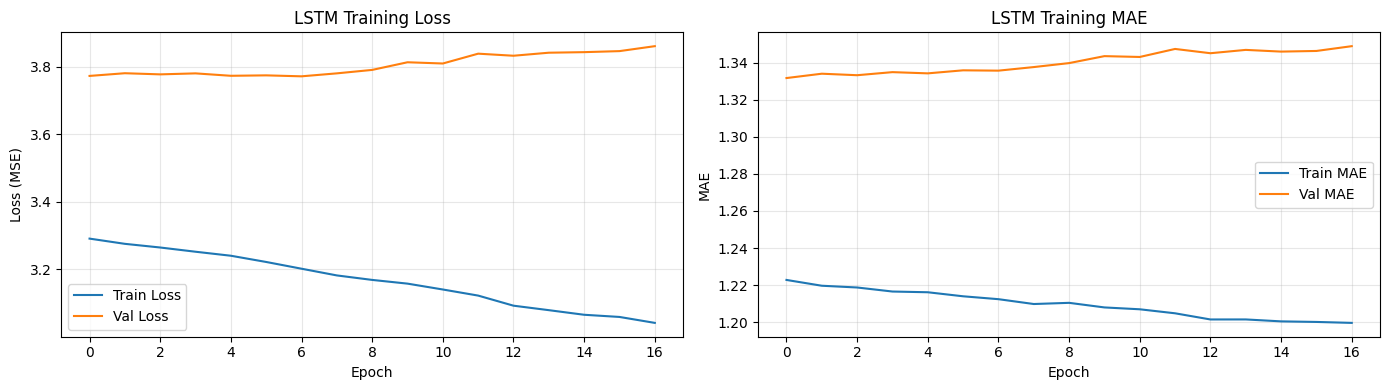


Results for LSTM (1-Day Autoregressive)

[ERROR BY HORIZON] Return Prediction:
  Day      MAE (%)      RMSE (%)
  -----------------------------------
  Day 1    1.311        1.867
  Day 2    1.312        1.883
  Day 3    1.313        1.886
  Day 4    1.315        1.887
  Day 5    1.318        1.894
  Day 6    1.320        1.896
  Day 7    1.320        1.897
  -----------------------------------
  Mean     1.316        1.887

[CLASSIFICATION] 7-Day Cumulative Direction:
  Accuracy:  53.23%
  Precision: 56.55%
  Recall:    51.46%
  F1-Score:  53.88%

[TRADING SIMULATION]:
  Initial Capital:   ₹3,498,000.00 (3498 trades × ₹1,000)
  Final Capital:     ₹3,519,733.82
  Total Return:      0.62%
  Number of Trades:  3498
  Win Rate:          54.80%
  Avg Return/Trade:  0.621%
  Sharpe Ratio:      0.1298

Training time: 217.58s
Epochs trained: 17
LSTM complete


In [20]:
# LSTM for 1-day prediction
print("Training LSTM...\n")

with mlflow.start_run(run_name="LSTM_1Day_Autoregressive"):
    # Hyperparameters
    lstm_units = 64
    dropout_rate = 0.2
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("lstm_units", lstm_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("prediction_mode", "autoregressive")
    
    start_time = time.time()
    
    # Build model
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, n_features)),
        layers.LSTM(lstm_units),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Predict 1-day return
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train_scaled, y_return_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Autoregressive prediction
    print("\nMaking autoregressive predictions on test stocks...")
    y_return_pred_list = []
    y_return_true_list = []
    
    for symbol in tqdm(test_symbols, desc="Predicting test stocks"):
        df = stock_data[symbol]
        
        for i in range(len(df) - WINDOW_SIZE - HORIZON + 1):
            initial_window = df[feature_cols].values[i:i + WINDOW_SIZE]
            
            true_closes = df['Close'].values[i + WINDOW_SIZE:i + WINDOW_SIZE + HORIZON]
            current_close = df['Close'].values[i + WINDOW_SIZE - 1]
            true_returns = [(true_closes[j] - (true_closes[j-1] if j > 0 else current_close)) / 
                           (true_closes[j-1] if j > 0 else current_close) * 100 
                           for j in range(len(true_closes))]
            
            pred_returns, _, _ = autoregressive_predict_7days(model, initial_window, scaler_X, HORIZON)
            
            y_return_pred_list.append(pred_returns)
            y_return_true_list.append(true_returns)
    
    # Evaluate
    horizon_metrics = calculate_metrics_by_horizon(y_return_true_list, y_return_pred_list, HORIZON)
    dir_metrics = calculate_direction_metrics(y_return_true_list, y_return_pred_list)
    trading_metrics = simulate_trading_autoregressive(y_return_true_list, y_return_pred_list)
    
    # Log to MLflow
    for key, val in {**horizon_metrics, **dir_metrics, **trading_metrics}.items():
        mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    mlflow.keras.log_model(model, "model")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('LSTM Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('LSTM Training MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/tmp/lstm_autoregressive_training.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('/tmp/lstm_autoregressive_training.png')
    plt.show()
    
    print_evaluation_summary("LSTM (1-Day Autoregressive)", 
                            horizon_metrics, dir_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("LSTM complete")

### 7.3 GRU Model

In [13]:
# GRU for 1-day prediction
print("Training GRU...\n")

with mlflow.start_run(run_name="GRU_1Day_Autoregressive"):
    # Hyperparameters
    gru_units = 64
    dropout_rate = 0.2
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    
    mlflow.log_param("model_type", "GRU")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("gru_units", gru_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("prediction_mode", "autoregressive")
    
    start_time = time.time()
    
    # Build model
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, n_features)),
        layers.GRU(gru_units),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train_scaled, y_return_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Autoregressive prediction
    print("\nMaking autoregressive predictions on test stocks...")
    y_return_pred_list = []
    y_return_true_list = []
    
    for symbol in tqdm(test_symbols, desc="Predicting test stocks"):
        df = stock_data[symbol]
        
        for i in range(len(df) - WINDOW_SIZE - HORIZON + 1):
            initial_window = df[feature_cols].values[i:i + WINDOW_SIZE]
            
            true_closes = df['Close'].values[i + WINDOW_SIZE:i + WINDOW_SIZE + HORIZON]
            current_close = df['Close'].values[i + WINDOW_SIZE - 1]
            true_returns = [(true_closes[j] - (true_closes[j-1] if j > 0 else current_close)) / 
                           (true_closes[j-1] if j > 0 else current_close) * 100 
                           for j in range(len(true_closes))]
            
            pred_returns, _, _ = autoregressive_predict_7days(model, initial_window, scaler_X, HORIZON)
            
            y_return_pred_list.append(pred_returns)
            y_return_true_list.append(true_returns)
    
    # Evaluate
    horizon_metrics = calculate_metrics_by_horizon(y_return_true_list, y_return_pred_list, HORIZON)
    dir_metrics = calculate_direction_metrics(y_return_true_list, y_return_pred_list)
    trading_metrics = simulate_trading_autoregressive(y_return_true_list, y_return_pred_list)
    
    # Log to MLflow
    for key, val in {**horizon_metrics, **dir_metrics, **trading_metrics}.items():
        mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    mlflow.keras.log_model(model, "model")
    
    print_evaluation_summary("GRU (1-Day Autoregressive)", 
                            horizon_metrics, dir_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("GRU complete")

Training GRU...



2025-11-13 21:31:15.090946: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-11-13 21:31:16.656676: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 88048800 exceeds 10% of free system memory.


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.2926 - mae: 1.2266

2025-11-13 21:31:30.347673: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 22014000 exceeds 10% of free system memory.


383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 3.3024 - mae: 1.2276 - val_loss: 3.7631 - val_mae: 1.3310 - learning_rate: 0.0010
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 3.2750 - mae: 1.2205 - val_loss: 3.7620 - val_mae: 1.3320 - learning_rate: 0.0010
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 3.2604 - mae: 1.2187 - val_loss: 3.7621 - val_mae: 1.3337 - learning_rate: 0.0010
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 3.2460 - mae: 1.2180 - val_loss: 3.7622 - val_mae: 1.3351 - learning_rate: 0.0010
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 3.2283 - mae: 1.2157 - val_loss: 3.7587 - val_mae: 1.3342 - learning_rate: 0.0010
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 3.2178 - mae: 1.2158 - val_loss: 3.7677 - val_mae: 1.3370 - learning_rate: 0.0010
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 3.2070 - mae: 1.2143 - val_loss: 3.7641 - val_mae: 1.3369 - learning_rate: 0.0010
Epo

Predicting test stocks:   0%|          | 0/19 [00:00<?, ?it/s]

2025/11/13 23:00:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 23:00:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/13 23:03:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 23:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for GRU (1-Day Autoregressive)

[ERROR BY HORIZON] Return Prediction:
  Day      MAE (%)      RMSE (%)
  -----------------------------------
  Day 1    1.308        1.852
  Day 2    1.312        1.884
  Day 3    1.315        1.888
  Day 4    1.317        1.889
  Day 5    1.321        1.898
  Day 6    1.323        1.900
  Day 7    1.324        1.900
  -----------------------------------
  Mean     1.317        1.887

[CLASSIFICATION] 7-Day Cumulative Direction:
  Accuracy:  52.74%
  Precision: 56.28%
  Recall:    49.30%
  F1-Score:  52.56%

[TRADING SIMULATION]:
  Initial Capital:   ₹3,367,000.00 (3367 trades × ₹1,000)
  Final Capital:     ₹3,384,968.42
  Total Return:      0.53%
  Number of Trades:  3367
  Win Rate:          54.44%
  Avg Return/Trade:  0.534%
  Sharpe Ratio:      0.1122

Training time: 321.19s
Epochs trained: 20
GRU complete


---
## 8. Results Summary & Comparison

In [16]:
# Query all runs
experiment = mlflow.get_experiment_by_name("stock-autoregressive-1day-prediction")
runs_df = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.sharpe_ratio DESC"]
)

print(f"Total runs: {len(runs_df)}\n")

summary_cols = [
    'tags.mlflow.runName',
    'metrics.accuracy',
    'metrics.mean_mae',
    'metrics.mae_day1',
    'metrics.mae_day7',
    'metrics.sharpe_ratio',
    'metrics.total_return_pct',
    'metrics.train_time_seconds'
]

summary_df = runs_df[summary_cols].copy()
summary_df.columns = ['Model', 'Accuracy', 'Mean MAE', 'Day1 MAE', 'Day7 MAE', 'Sharpe', 'Total Return %', 'Train Time (s)']
summary_df = summary_df.sort_values('Sharpe', ascending=False)

print("\n" + "="*110)
print("MODEL COMPARISON - Autoregressive 1-Day Prediction")
print("="*110)
print(summary_df.to_string(index=False))
print("="*110)

# Error propagation analysis
if len(summary_df) > 0:
    print("\n[ERROR PROPAGATION ANALYSIS]")
    print("How errors compound from Day 1 to Day 7:\n")
    for idx, row in summary_df.iterrows():
        print(f"{row['Model']}:")
        print(f"  Day 1 MAE: {row['Day1 MAE']:.3f}%")
        print(f"  Day 7 MAE: {row['Day7 MAE']:.3f}%")
        print(f"  Error Growth: {(row['Day7 MAE'] / row['Day1 MAE'] - 1) * 100:.1f}%\n")

Total runs: 3


MODEL COMPARISON - Autoregressive 1-Day Prediction
                   Model  Accuracy  Mean MAE  Day1 MAE  Day7 MAE   Sharpe  Total Return %  Train Time (s)
  Linear_Regression_1Day  0.547451  1.476467  1.302636  1.655682 0.141501        0.676665        4.931827
LSTM_1Day_Autoregressive  0.532256  1.315698  1.310767  1.320289 0.129842        0.621321      217.579414
 GRU_1Day_Autoregressive  0.527421  1.317195  1.308495  1.323549 0.112239        0.533663      321.185538

[ERROR PROPAGATION ANALYSIS]
How errors compound from Day 1 to Day 7:

Linear_Regression_1Day:
  Day 1 MAE: 1.303%
  Day 7 MAE: 1.656%
  Error Growth: 27.1%

LSTM_1Day_Autoregressive:
  Day 1 MAE: 1.311%
  Day 7 MAE: 1.320%
  Error Growth: 0.7%

GRU_1Day_Autoregressive:
  Day 1 MAE: 1.308%
  Day 7 MAE: 1.324%
  Error Growth: 1.2%



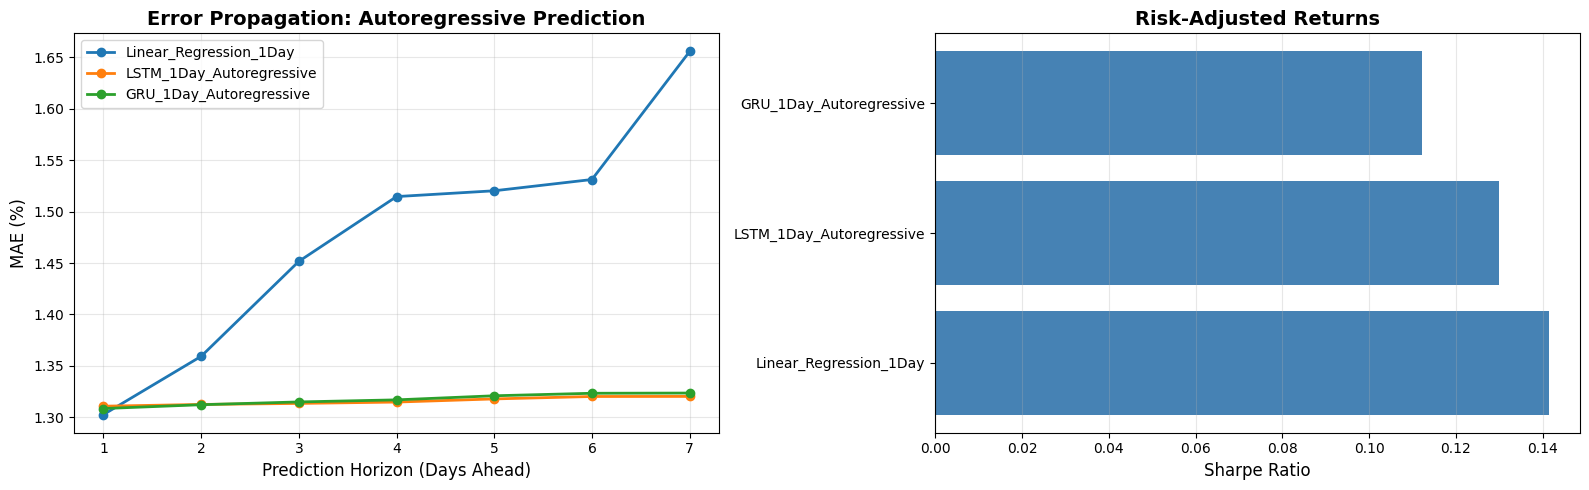

Visualization complete


In [17]:
# Visualization: Error by horizon
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot MAE by day for each model
for idx, row in runs_df.iterrows():
    model_name = row['tags.mlflow.runName']
    mae_by_day = [row[f'metrics.mae_day{d}'] for d in range(1, 8)]
    axes[0].plot(range(1, 8), mae_by_day, marker='o', linewidth=2, label=model_name)

axes[0].set_xlabel('Prediction Horizon (Days Ahead)', fontsize=12)
axes[0].set_ylabel('MAE (%)', fontsize=12)
axes[0].set_title('Error Propagation: Autoregressive Prediction', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 8))

# Sharpe ratio comparison
axes[1].barh(summary_df['Model'], summary_df['Sharpe'], color='steelblue')
axes[1].set_xlabel('Sharpe Ratio', fontsize=12)
axes[1].set_title('Risk-Adjusted Returns', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/autoregressive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization complete")

---
## Summary

### Key Findings:

### Next Steps:

### MLflow UI:
```bash
cd <project directory>
uv run mlflow ui --port 5000
# Visit: http://localhost:5000
```

---

**Notebook Complete!**